👇 Workflow: FE-generated data for `footprint-to-pressure` network training.
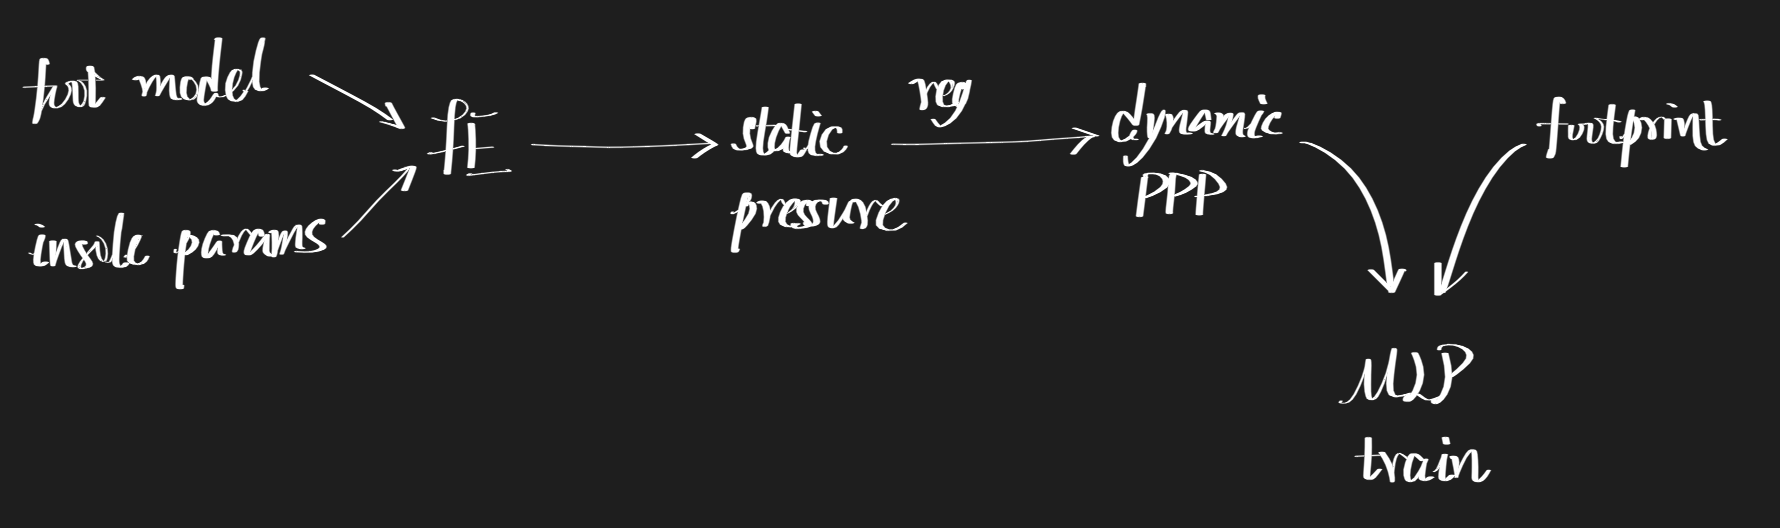

In [112]:
import torch
torch.manual_seed(0)

In [113]:
if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

device

'mps'

## Data loading

In [124]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from torch.utils.data import Dataset

class Pedar_Dataset_static2dynamic(Dataset):
    def __init__(self, static_path: str, dynamic_path: str, sense_range: float = 600, dtype = torch.float32, transform = None, target_transform = None):
        self.pedar_static = pd.read_pickle(static_path)
        self.pedar_dynamic = pd.read_pickle(dynamic_path)
        self.index = self.pedar_static.index
        
        self.dtype = dtype
        self.sense_range = sense_range

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx: int):
        # get corresponding static and dynamic pressure data
        # transform to torch tensor and divide by the sense range
        static_pressure = torch.from_numpy(self.pedar_static.loc[self.index[idx], :].values).type(self.dtype) / self.sense_range
        dynamic_pressure = torch.from_numpy(self.pedar_dynamic.loc[self.index[idx], :].values).type(self.dtype) / self.sense_range

        if self.transform:
            static_pressure = self.transform(static_pressure)
        if self.target_transform:
            dynamic_pressure = self.target_transform(dynamic_pressure)

        return static_pressure, dynamic_pressure
    
    def draw_heatmap(self, arr: np.array, l_mask_path: str = 'config/left_foot_mask.png', plot: bool = True, vmin: float = 0.0, vmax: float = 600.0):
        # load foot masks
        l_img = Image.open(l_mask_path)
        r_img = ImageOps.mirror(l_img)

        l_mask = np.array(l_img).astype(np.float64)
        r_mask = np.array(r_img).astype(np.float64)

        # detect pixels of area no.1~197 and store the corresponding indexes
        l_index = {}
        r_index = {}

        for n in range(0, 198):
            l_index[n] = np.where(l_mask == n + 1)
            r_index[n + 99] = np.where(r_mask == n + 1)

        # create left and right foot heatmap
        l_pedar = np.zeros(l_mask.shape)
        r_pedar = np.zeros(r_mask.shape)

        for idx, value in enumerate(arr):
            if idx <= 99:
                # filling left foot area
                l_pedar[l_index[idx]] = value * self.sense_range

            else:
                # filling right foot area
                r_pedar[r_index[idx]] = value * self.sense_range

        # plot heatmap
        if plot:
            fig, axs = plt.subplots(1, 2)
            
            im = axs[0].imshow(l_pedar, vmin=vmin, vmax=vmax)
            axs[0].set_title('left')
            axs[0].axis('off')
            fig.colorbar(im, ax=axs[0])

            im = axs[1].imshow(r_pedar, vmin=vmin, vmax=vmax)
            axs[1].set_title('right')
            axs[1].axis('off')
            fig.colorbar(im, ax=axs[1])

            plt.show()

dataset = Pedar_Dataset_static2dynamic(static_path='output/pedar_static.pkl', dynamic_path='output/pedar_dynamic.pkl')

In [115]:
from torch.utils.data import random_split

dataset = Pedar_Dataset_static2dynamic(static_path='output/pedar_static.pkl', dynamic_path='output/pedar_dynamic.pkl')
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
len(train_dataset), len(test_dataset)

(240, 60)

In [116]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Training & testing scheme

In [117]:
from typing import Dict, List, Tuple

def train_step(
        model: torch.nn.Module, 
        dataloader: torch.utils.data.DataLoader, 
        loss_fn: torch.nn.Module, 
        optimizer: torch.optim.Optimizer,
        device: torch.device) -> Tuple[float, float]:
    # put model in train mode
    model.train()
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        # send data to device
        X, y = X.to(device), y.to(device)

        # forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # loss backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # return metric
    train_loss = train_loss / len(dataloader)
    return train_loss

In [118]:
def test_step(
        model: torch.nn.Module, 
        dataloader: torch.utils.data.DataLoader, 
        loss_fn: torch.nn.Module,
        device: torch.device) -> Tuple[float, float]:
    # put model in eval mode
    model.eval() 
    test_loss = 0

    # turn on inference context manager
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # send data to target device
            X, y = X.to(device), y.to(device)

            # forward pass
            test_pred_logits = model(X)

            # loss calculation
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

    # return metric
    test_loss = test_loss / len(dataloader)
    return test_loss

In [119]:
from tqdm.auto import tqdm

def train(
        model: torch.nn.Module, 
        train_dataloader: torch.utils.data.DataLoader, 
        test_dataloader: torch.utils.data.DataLoader, 
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        epochs: int,
        device: torch.device) -> Dict[str, List]:
    # create results dict
    results = {
        "train_loss": [],
        "test_loss": [],
    }

    for epoch in tqdm(range(epochs)):
        train_loss = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            )
        
        test_loss = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device,
            )

        # logs
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} | "
        )

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return results

## MLP: `static` -> `dynamic` pressure regressor

In [120]:
from torch import nn

class MLP(nn.Module):
    def __init__(self, input_size: int = 198, hidden_size: int = 256, output_size: int = 198):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, hidden_size * 2),
            nn.Sigmoid(),
            nn.Linear(hidden_size * 2, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [121]:
model = MLP(hidden_size=256).to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

results = train(model, train_dataloader, test_dataloader, optimizer, loss, epochs=100, device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1660 | test_loss: 0.1611 | 
Epoch: 2 | train_loss: 0.1554 | test_loss: 0.1506 | 
Epoch: 3 | train_loss: 0.1452 | test_loss: 0.1409 | 
Epoch: 4 | train_loss: 0.1357 | test_loss: 0.1318 | 
Epoch: 5 | train_loss: 0.1269 | test_loss: 0.1230 | 
Epoch: 6 | train_loss: 0.1183 | test_loss: 0.1150 | 
Epoch: 7 | train_loss: 0.1107 | test_loss: 0.1074 | 
Epoch: 8 | train_loss: 0.1035 | test_loss: 0.1004 | 
Epoch: 9 | train_loss: 0.0965 | test_loss: 0.0937 | 
Epoch: 10 | train_loss: 0.0900 | test_loss: 0.0876 | 
Epoch: 11 | train_loss: 0.0840 | test_loss: 0.0818 | 
Epoch: 12 | train_loss: 0.0785 | test_loss: 0.0764 | 
Epoch: 13 | train_loss: 0.0734 | test_loss: 0.0713 | 
Epoch: 14 | train_loss: 0.0684 | test_loss: 0.0666 | 
Epoch: 15 | train_loss: 0.0639 | test_loss: 0.0623 | 
Epoch: 16 | train_loss: 0.0598 | test_loss: 0.0582 | 
Epoch: 17 | train_loss: 0.0559 | test_loss: 0.0545 | 
Epoch: 18 | train_loss: 0.0524 | test_loss: 0.0509 | 
Epoch: 19 | train_loss: 0.0490 | test

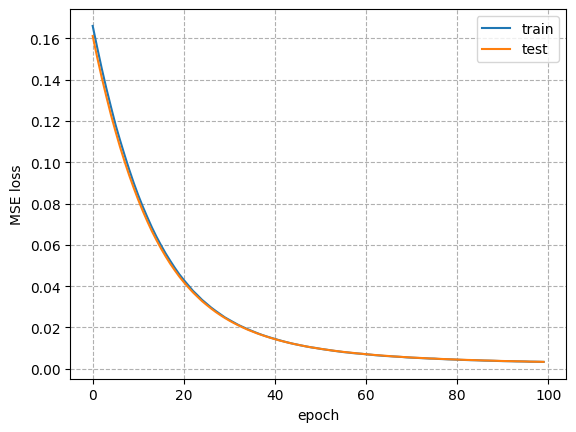

In [122]:
from matplotlib import pyplot as pyplot

plt.plot(results['train_loss'], label='train')
plt.plot(results['test_loss'], label='test')

plt.ylabel('MSE loss')
plt.xlabel('epoch')
plt.legend()
plt.grid(linestyle='--')
plt.show()

input - static


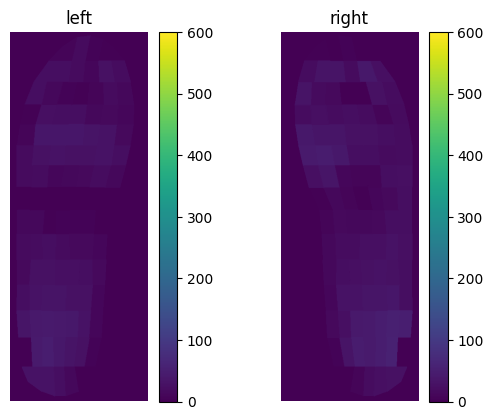

output - dynamic


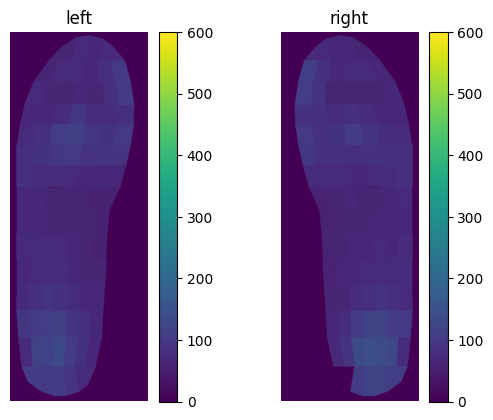

target - dynamic


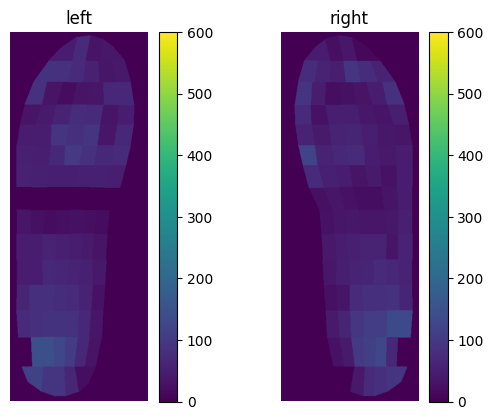

In [128]:
input, target = test_dataset[0]
output = model(input.to(device))

print('input - static')
dataset.draw_heatmap(input.cpu().detach().numpy())

print('output - dynamic')
dataset.draw_heatmap(output.cpu().detach().numpy())

print('target - dynamic')
dataset.draw_heatmap(target.cpu().detach().numpy())